In [1]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm 
import numpy as np
from skimage.transform import resize

import matplotlib.pyplot as plt
import matplotlib

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3,4" #avoid GPUS used by others
from sklearn.utils import shuffle

/home/mcherukara/miniconda3/envs/PyTorch1.11/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.style.use('seaborn-white')
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20
plt.viridis()

<Figure size 432x288 with 0 Axes>

In [3]:
def plot3(data,titles):
    if(len(titles)<3):
        titles=["Plot1", "Plot2", "Plot3"]
    fig,ax = plt.subplots(1,3, figsize=(20,12))
    im=ax[0].imshow(data[0])
    ax[0].set_title(titles[0])
    ax[0].axis('off')
    plt.colorbar(im,ax=ax[0], fraction=0.046, pad=0.04)
    im=ax[1].imshow(data[1])
    ax[1].set_title(titles[1])
    ax[1].axis('off')
    plt.colorbar(im,ax=ax[1], fraction=0.046, pad=0.04)
    im=ax[2].imshow(data[2])
    ax[2].set_title(titles[2])
    ax[2].axis('off')
    plt.colorbar(im,ax=ax[2], fraction=0.046, pad=0.04)

In [4]:
EPOCHS = 12
NGPUS = 2
NGPUS = min(torch.cuda.device_count(), NGPUS)
BATCH_SIZE = NGPUS * 64
LR = NGPUS * 1e-3
print("GPUs:", NGPUS, "Batch size:", BATCH_SIZE, "Learning rate:", LR)

GPUs: 2 Batch size: 128 Learning rate: 0.002


In [5]:
H,W = 64,64
NLINES = 100 #How many lines of data to use for training?
NLTEST = 60 #How many lines for the test set?

N_VALID = 805 #How much to reserve for validation

In [6]:
path = os.getcwd()

MODEL_SAVE_PATH = path +'/trained_model/'
if (not os.path.isdir(MODEL_SAVE_PATH)):
    os.mkdir(MODEL_SAVE_PATH)

In [7]:
data_diffr = np.load(path+'/../../data/20191008_39_diff.npz')['arr_0']
real_space = np.load(path+'/../../data/20191008_39_amp_pha_10nm_full.npy')
amp = np.abs(real_space)
ph = np.angle(real_space)
amp.shape

(161, 161, 64, 64)

In [8]:
print(data_diffr.shape)
#plt.matshow(np.log10(data_diffr[0,0]))

data_diffr_red = np.zeros((data_diffr.shape[0],data_diffr.shape[1],64,64), float)
for i in tqdm(range(data_diffr.shape[0])):
    for j in range(data_diffr.shape[1]):
        data_diffr_red[i,j] = resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
        data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3,0,data_diffr_red[i,j])

(161, 161, 256, 256)


100%|██████████| 161/161 [00:17<00:00,  9.02it/s]


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


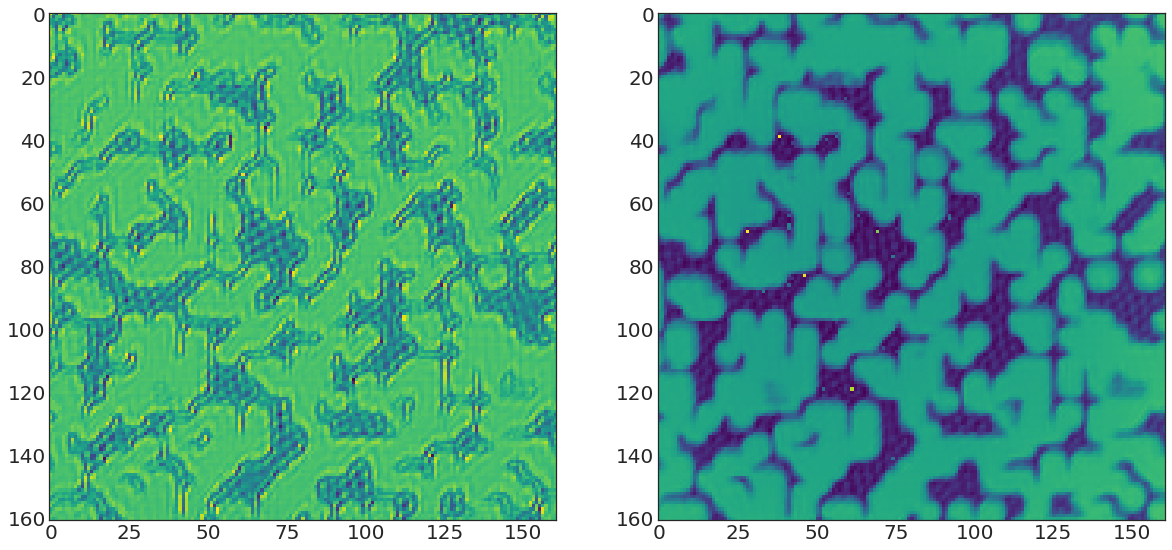

In [9]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(amp[:,:,32,32])
ax[1].imshow(ph[:,:,32,32])

In [10]:
tst_strt = amp.shape[0]-NLTEST #Where to index from
print(tst_strt)

X_train = data_diffr_red[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
X_test = data_diffr_red[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_train = amp[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_test = amp[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_phi_train = ph[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_phi_test = ph[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]

ntrain = X_train.shape[0]*X_train.shape[1]
ntest = X_test.shape[0]*X_test.shape[1]

print(X_train.shape, X_test.shape)

X_train, Y_I_train, Y_phi_train = shuffle(X_train, Y_I_train, Y_phi_train, random_state=0)

101
(16100, 1, 64, 64) (3600, 1, 64, 64)


In [11]:
#Training data
X_train_tensor = torch.Tensor(X_train) 
Y_I_train_tensor = torch.Tensor(Y_I_train) 
Y_phi_train_tensor = torch.Tensor(Y_phi_train)

#Test data
X_test_tensor = torch.Tensor(X_test) 
Y_I_test_tensor = torch.Tensor(Y_I_test) 
Y_phi_test_tensor = torch.Tensor(Y_phi_test)

print(Y_phi_train.max(), Y_phi_train.min())

print(X_train_tensor.shape, Y_I_train_tensor.shape, Y_phi_train_tensor.shape)

train_data = TensorDataset(X_train_tensor,Y_I_train_tensor,Y_phi_train_tensor)
test_data = TensorDataset(X_test_tensor)

3.1268637 -1.564053
torch.Size([16100, 1, 64, 64]) torch.Size([16100, 1, 64, 64]) torch.Size([16100, 1, 64, 64])


In [12]:
N_TRAIN = X_train_tensor.shape[0]
train_data2, valid_data = torch.utils.data.random_split(train_data,[N_TRAIN-N_VALID,N_VALID])
print(len(train_data2),len(valid_data),len(test_data))

15295 805 3600


In [13]:
trainloader = DataLoader(train_data2, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
validloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [14]:
nconv = 32


class recon_model(nn.Module):

    def __init__(self):
        super(recon_model, self).__init__()


        self.encoder = nn.Sequential( # Appears sequential has similar functionality as TF avoiding need for separate model definition and activ
          nn.Conv2d(in_channels=1, out_channels=nconv, kernel_size=3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv, nconv, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.MaxPool2d((2,2)),

          nn.Conv2d(nconv, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),          
          nn.ReLU(),
          nn.MaxPool2d((2,2)),

          nn.Conv2d(nconv*2, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),          
          nn.ReLU(),
          nn.MaxPool2d((2,2)),
          )

        self.decoder1 = nn.Sequential(

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),
            
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*2, 1, 3, stride=1, padding=(1,1)),
          nn.Sigmoid() #Amplitude model
          )

        self.decoder2 = nn.Sequential(

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),
            
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*2, 1, 3, stride=1, padding=(1,1)),
          nn.Tanh() #Phase model
          )
    
    def forward(self,x):
        x1 = self.encoder(x)
        amp = self.decoder1(x1)
        ph = self.decoder2(x1)

        #Restore -pi to pi range
        ph = ph*np.pi #Using tanh activation (-1 to 1) for phase so multiply by pi

        return amp,ph

In [15]:
model = recon_model()
for ft_images,amps,phs in trainloader:
    print("batch size:", ft_images.shape)
    amp, ph = model(ft_images)
    print(amp.shape, ph.shape)
    print(amp.dtype, ph.dtype)
    break

batch size: torch.Size([128, 1, 64, 64])
torch.Size([128, 1, 64, 64]) torch.Size([128, 1, 64, 64])
torch.float32 torch.float32


In [16]:
summary(model,(1,H,W),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
              ReLU-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 32, 64, 64]           9,248
              ReLU-4           [-1, 32, 64, 64]               0
         MaxPool2d-5           [-1, 32, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          18,496
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,928
              ReLU-9           [-1, 64, 32, 32]               0
        MaxPool2d-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]          73,856
             ReLU-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]         147,584
             ReLU-14          [-1, 128,

In [17]:
#Function to update saved model if validation loss is minimum
def update_saved_model(model, path):
    if not os.path.isdir(path):
        os.mkdir(path)
    for f in os.listdir(path):
        os.remove(os.path.join(path, f))
    if (NGPUS>1):    
        torch.save(model.module.state_dict(),path+'best_model.pth') #Have to save the underlying model else will always need 4 GPUs
    else:
        torch.save(model,path+'best_model.pth')

In [18]:
def calc_step_size():
  iterations_per_epoch = np.floor((N_TRAIN-N_VALID)/BATCH_SIZE)+1 
  #Final batch will be less than batch size
  step_size = 6*iterations_per_epoch 
  #Paper recommends 2-10 number of iterations, step_size is half cycle
  return step_size, iterations_per_epoch
  
def train(model, optimizer, scheduler, criterion, trainloader,metrics):
    tot_loss = 0.0
    loss_amp = 0.0
    loss_ph = 0.0
    
    for i, (ft_images,amps,phs) in tqdm(enumerate(trainloader)):

        pred_amps, pred_phs = model(ft_images) #Forward pass

        #Compute losses
        loss_a = criterion(pred_amps,amps) #Monitor amplitude loss
        loss_p = criterion(pred_phs,phs) #Monitor phase loss but only within support (which may not be same as true amp)
        loss = loss_a + loss_p #Use equiweighted amps and phase

        #Zero current grads and do backprop
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

        tot_loss += loss.detach().item()
        loss_amp += loss_a.detach().item()
        loss_ph += loss_p.detach().item()

        #Update the LR according to the schedule -- CyclicLR updates each batch
        scheduler.step() 
        metrics['lrs'].append(scheduler.get_last_lr())
        
        
    #Divide cumulative loss by number of batches-- sli inaccurate because last batch is different size
    metrics['losses'].append([tot_loss/i,loss_amp/i,loss_ph/i]) 
    

def validate(model, criterion, validloader,metrics):
    tot_val_loss = 0.0
    val_loss_amp = 0.0
    val_loss_ph = 0.0

    for j, (ft_images,amps,phs) in enumerate(validloader):

        pred_amps, pred_phs = model(ft_images) #Forward pass
    
        val_loss_a = criterion(pred_amps,amps) 
        val_loss_p = criterion(pred_phs,phs)
        val_loss = val_loss_a + val_loss_p
    
        tot_val_loss += val_loss.detach().item()
        val_loss_amp += val_loss_a.detach().item()
        val_loss_ph += val_loss_p.detach().item()  
    metrics['val_losses'].append([tot_val_loss/j,val_loss_amp/j,val_loss_ph/j])
  
  #Update saved model if val loss is lower
    if(tot_val_loss/j<metrics['best_val_loss']):
        print("Saving improved model after Val Loss improved from %.5f to %.5f" %(metrics['best_val_loss'],tot_val_loss/j))
        metrics['best_val_loss'] = tot_val_loss/j
        update_saved_model(model, MODEL_SAVE_PATH)

In [19]:


metrics = {'losses':[],'val_losses':[], 'lrs':[], 'best_val_loss' : np.inf}
from pytorch_lightning.lite import LightningLite

class Lite(LightningLite):

  def run(self, EPOCHS, trainloader, validloader):

    model = recon_model()

    #Optimizer details
    step_size, iterations_per_epoch = calc_step_size()
    print("LR step size is:", step_size, "which is every %d epochs" %(step_size/iterations_per_epoch))

    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr = LR)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR/10, max_lr=LR, step_size_up=step_size,
                                                  cycle_momentum=False, mode='triangular2')

    model, optimizer = self.setup(model, optimizer)

    #Scale dataloaders
    trainloader = self.setup_dataloaders(trainloader)
    validloader = self.setup_dataloaders(validloader)

    for epoch in range (EPOCHS):
        
      #Set model to train mode
      model.train() 
        
      #Training loop
      train(model, optimizer, scheduler, criterion, trainloader,metrics)

        
      #Switch model to eval mode
      model.eval()
        
      #Validation loop
      validate(model, criterion, validloader, metrics)
      
      print('Epoch: %d | FT  | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][0], metrics['val_losses'][-1][0]))
      print('Epoch: %d | Amp | Train Loss: %.4f | Val Loss: %.4f' %(epoch, metrics['losses'][-1][1], metrics['val_losses'][-1][1]))
      print('Epoch: %d | Ph  | Train Loss: %.3f | Val Loss: %.3f' %(epoch, metrics['losses'][-1][2], metrics['val_losses'][-1][2]))
      print('Epoch: %d | Ending LR: %.6f ' %(epoch, metrics['lrs'][-1][0]))

In [20]:

Lite(strategy='dp', devices=NGPUS, accelerator="gpu").run(EPOCHS, trainloader, validloader)

LR step size is: 720.0 which is every 6 epochs


120it [00:10, 11.39it/s]


Saving improved model after Val Loss improved from inf to 0.85393
Epoch: 0 | FT  | Train Loss: 0.77863 | Val Loss: 0.85393
Epoch: 0 | Amp | Train Loss: 0.0943 | Val Loss: 0.1012
Epoch: 0 | Ph  | Train Loss: 0.684 | Val Loss: 0.753
Epoch: 0 | Ending LR: 0.000500 


120it [00:04, 26.19it/s]


Saving improved model after Val Loss improved from 0.85393 to 0.74505
Epoch: 1 | FT  | Train Loss: 0.69362 | Val Loss: 0.74505
Epoch: 1 | Amp | Train Loss: 0.0873 | Val Loss: 0.1014
Epoch: 1 | Ph  | Train Loss: 0.606 | Val Loss: 0.644
Epoch: 1 | Ending LR: 0.000800 


120it [00:04, 26.28it/s]


Saving improved model after Val Loss improved from 0.74505 to 0.67584
Epoch: 2 | FT  | Train Loss: 0.59998 | Val Loss: 0.67584
Epoch: 2 | Amp | Train Loss: 0.0877 | Val Loss: 0.1013
Epoch: 2 | Ph  | Train Loss: 0.512 | Val Loss: 0.575
Epoch: 2 | Ending LR: 0.001100 


120it [00:04, 26.32it/s]


Saving improved model after Val Loss improved from 0.67584 to 0.56968
Epoch: 3 | FT  | Train Loss: 0.51455 | Val Loss: 0.56968
Epoch: 3 | Amp | Train Loss: 0.0877 | Val Loss: 0.1014
Epoch: 3 | Ph  | Train Loss: 0.427 | Val Loss: 0.468
Epoch: 3 | Ending LR: 0.001400 


120it [00:04, 25.66it/s]


Saving improved model after Val Loss improved from 0.56968 to 0.52616
Epoch: 4 | FT  | Train Loss: 0.45993 | Val Loss: 0.52616
Epoch: 4 | Amp | Train Loss: 0.0877 | Val Loss: 0.1012
Epoch: 4 | Ph  | Train Loss: 0.372 | Val Loss: 0.425
Epoch: 4 | Ending LR: 0.001700 


120it [00:04, 26.53it/s]


Saving improved model after Val Loss improved from 0.52616 to 0.50234
Epoch: 5 | FT  | Train Loss: 0.42581 | Val Loss: 0.50234
Epoch: 5 | Amp | Train Loss: 0.0877 | Val Loss: 0.1014
Epoch: 5 | Ph  | Train Loss: 0.338 | Val Loss: 0.401
Epoch: 5 | Ending LR: 0.002000 


120it [00:04, 25.09it/s]


Saving improved model after Val Loss improved from 0.50234 to 0.45037
Epoch: 6 | FT  | Train Loss: 0.39639 | Val Loss: 0.45037
Epoch: 6 | Amp | Train Loss: 0.0877 | Val Loss: 0.1013
Epoch: 6 | Ph  | Train Loss: 0.309 | Val Loss: 0.349
Epoch: 6 | Ending LR: 0.001700 


120it [00:04, 25.83it/s]


Saving improved model after Val Loss improved from 0.45037 to 0.43501
Epoch: 7 | FT  | Train Loss: 0.35909 | Val Loss: 0.43501
Epoch: 7 | Amp | Train Loss: 0.0877 | Val Loss: 0.1013
Epoch: 7 | Ph  | Train Loss: 0.271 | Val Loss: 0.334
Epoch: 7 | Ending LR: 0.001400 


120it [00:04, 24.57it/s]


Saving improved model after Val Loss improved from 0.43501 to 0.38768
Epoch: 8 | FT  | Train Loss: 0.32757 | Val Loss: 0.38768
Epoch: 8 | Amp | Train Loss: 0.0877 | Val Loss: 0.1014
Epoch: 8 | Ph  | Train Loss: 0.240 | Val Loss: 0.286
Epoch: 8 | Ending LR: 0.001100 


120it [00:04, 25.73it/s]


Saving improved model after Val Loss improved from 0.38768 to 0.35355
Epoch: 9 | FT  | Train Loss: 0.29941 | Val Loss: 0.35355
Epoch: 9 | Amp | Train Loss: 0.0877 | Val Loss: 0.1014
Epoch: 9 | Ph  | Train Loss: 0.212 | Val Loss: 0.252
Epoch: 9 | Ending LR: 0.000800 


120it [00:04, 25.83it/s]


Saving improved model after Val Loss improved from 0.35355 to 0.33118
Epoch: 10 | FT  | Train Loss: 0.27506 | Val Loss: 0.33118
Epoch: 10 | Amp | Train Loss: 0.0877 | Val Loss: 0.1014
Epoch: 10 | Ph  | Train Loss: 0.187 | Val Loss: 0.230
Epoch: 10 | Ending LR: 0.000500 


120it [00:04, 25.63it/s]


Saving improved model after Val Loss improved from 0.33118 to 0.31768
Epoch: 11 | FT  | Train Loss: 0.25493 | Val Loss: 0.31768
Epoch: 11 | Amp | Train Loss: 0.0877 | Val Loss: 0.1014
Epoch: 11 | Ph  | Train Loss: 0.167 | Val Loss: 0.216
Epoch: 11 | Ending LR: 0.000200 


Text(0.5, 0, 'Epoch')

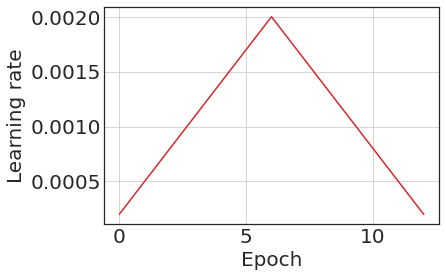

In [21]:
batches = np.linspace(0,len(metrics['lrs']),len(metrics['lrs'])+1)
step_size, iterations_per_epoch = calc_step_size()
epoch_list = batches/iterations_per_epoch

plt.plot(epoch_list[1:],metrics['lrs'], 'C3-')
plt.grid()
plt.ylabel("Learning rate")
plt.xlabel("Epoch")

Text(0.5, 45.5, 'Epochs')

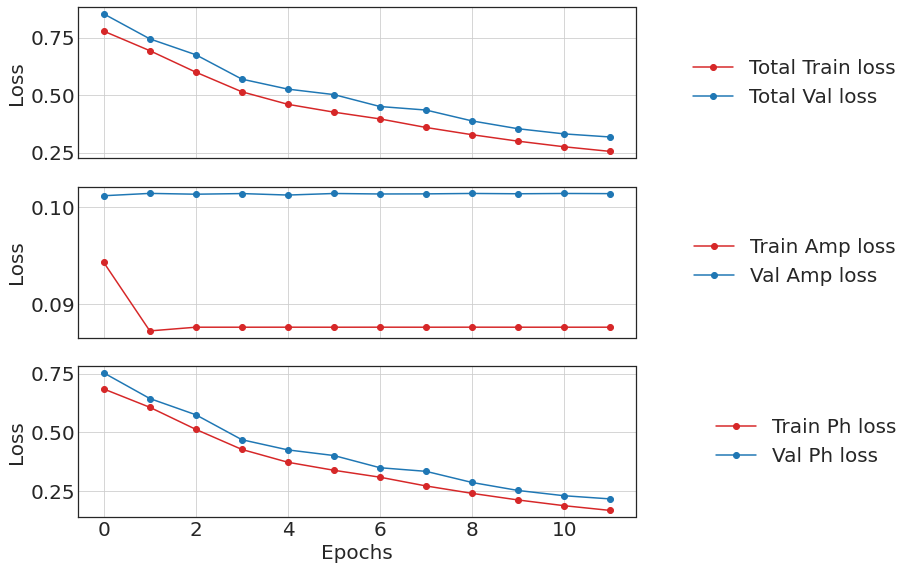

In [22]:
losses_arr = np.array(metrics['losses'])
val_losses_arr = np.array(metrics['val_losses'])
losses_arr.shape
fig, ax = plt.subplots(3,sharex=True, figsize=(15, 8))
ax[0].plot(losses_arr[:,0], 'C3o-', label = "Total Train loss")
ax[0].plot(val_losses_arr[:,0], 'C0o-', label = "Total Val loss")
ax[0].set(ylabel='Loss')
ax[0].grid()
ax[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[1].plot(losses_arr[:,1], 'C3o-', label = "Train Amp loss")
ax[1].plot(val_losses_arr[:,1], 'C0o-', label = "Val Amp loss")
ax[1].set(ylabel='Loss')
ax[1].grid()
ax[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[2].plot(losses_arr[:,2], 'C3o-', label = "Train Ph loss")
ax[2].plot(val_losses_arr[:,2], 'C0o-', label = "Val Ph loss")
ax[2].set(ylabel='Loss')
ax[2].grid()
ax[2].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

plt.tight_layout()
plt.xlabel("Epochs")

In [24]:
model.eval() #imp when have dropout etc
amps = []
phs = []
for i, ft_images in enumerate(testloader):
    ft_images = ft_images[0]
    amp, ph = model(ft_images)
    for j in range(ft_images.shape[0]):
        amps.append(amp[j].detach().to("cpu").numpy())
        phs.append(ph[j].detach().to("cpu").numpy())

In [25]:
amps = np.array(amps).squeeze()
phs = np.array(phs).squeeze()
print(amps.shape, amps.dtype)
print(phs.shape, phs.dtype)

(3600, 64, 64) float32
(3600, 64, 64) float32


<Figure size 432x288 with 0 Axes>

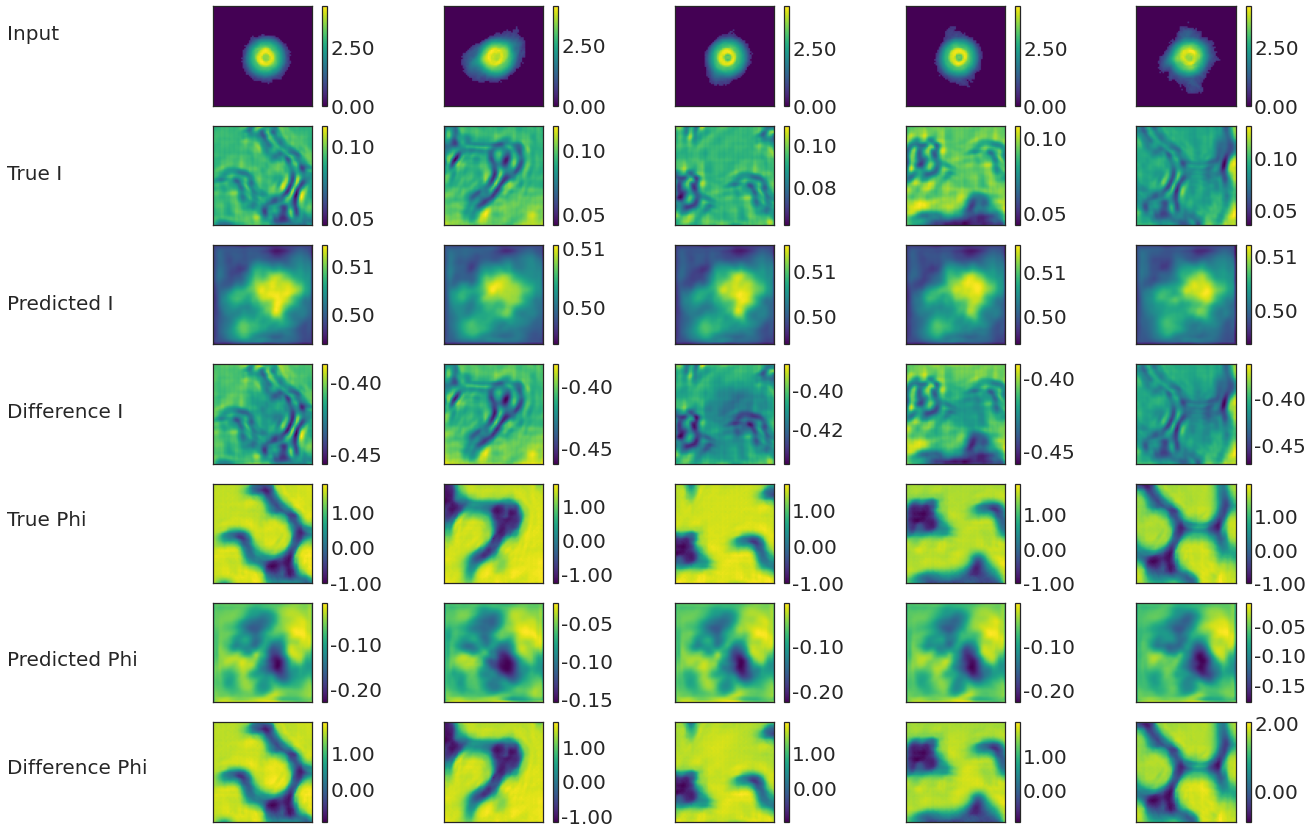

In [26]:
h,w = 64,64
ntest=amps.shape[0]
plt.viridis()
n = 5
f,ax=plt.subplots(7,n,figsize=(20, 15))
plt.gcf().text(0.02, 0.85, "Input", fontsize=20)
plt.gcf().text(0.02, 0.72, "True I", fontsize=20)
plt.gcf().text(0.02, 0.6, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.5, "Difference I", fontsize=20)
plt.gcf().text(0.02, 0.4, "True Phi", fontsize=20)
plt.gcf().text(0.02, 0.27, "Predicted Phi", fontsize=20)
plt.gcf().text(0.02, 0.17, "Difference Phi", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

        # display FT
    im=ax[0,i].imshow(np.log10(X_test[j].reshape(h, w)+1))
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)

    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(amps[j].reshape(h, w))
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)
    
        # display original phase
    im=ax[4,i].imshow(Y_phi_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[4,i], format='%.2f')
    ax[4,i].get_xaxis().set_visible(False)
    ax[4,i].get_yaxis().set_visible(False)
    
    # display predicted phase
    im=ax[5,i].imshow(phs[j].reshape(h, w))
    plt.colorbar(im, ax=ax[5,i], format='%.2f')
    ax[5,i].get_xaxis().set_visible(False)
    ax[5,i].get_yaxis().set_visible(False)
    
    #Difference in amplitude
    im=ax[3,i].imshow(Y_I_test[j].reshape(h, w)-amps[j].reshape(h, w))
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
    
    # Difference in phase
    im=ax[6,i].imshow(Y_phi_test[j].reshape(h, w)-phs[j].reshape(h, w))
    plt.colorbar(im, ax=ax[6,i], format='%.2f')
    ax[6,i].get_xaxis().set_visible(False)
    ax[6,i].get_yaxis().set_visible(False)
    
plt.show()

In [27]:
point_size = 3
overlap = 4*point_size

In [28]:
tst_side = 60

composite_amp = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_amp)
data_reshaped = amps.reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_amp[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

In [29]:

composite_phase = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_phase)
data_reshaped = phs.reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_phase[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

In [30]:
stitched_phase = composite_phase[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp = composite_amp[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp_down = resize(stitched_amp, (60,60), preserve_range=True, anti_aliasing=True)
stitched_phase_down = resize(stitched_phase, (60,60), preserve_range=True, anti_aliasing=True)

In [31]:
true_amp = Y_I_test.reshape(NLTEST,NLTEST,64,64)
true_ph = Y_phi_test.reshape(NLTEST,NLTEST,64,64)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


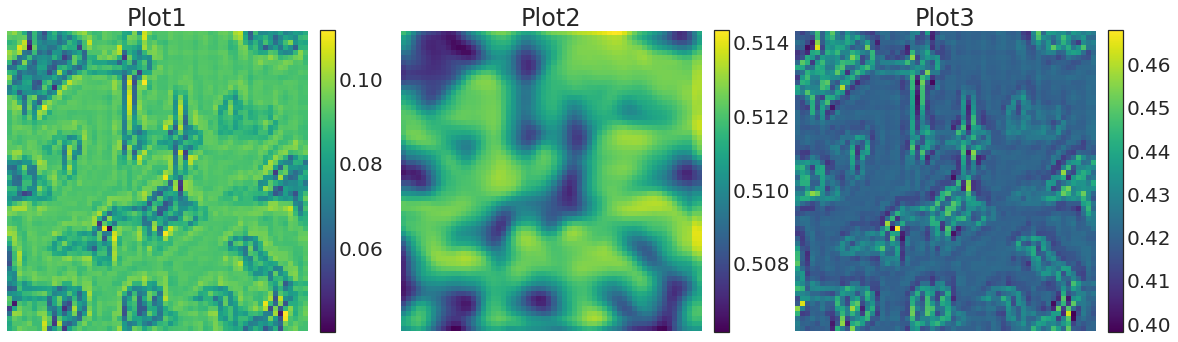

In [32]:
plot3([true_amp[:,:,32,32],stitched_amp_down,stitched_amp_down-true_amp[:,:,32,32]],[])

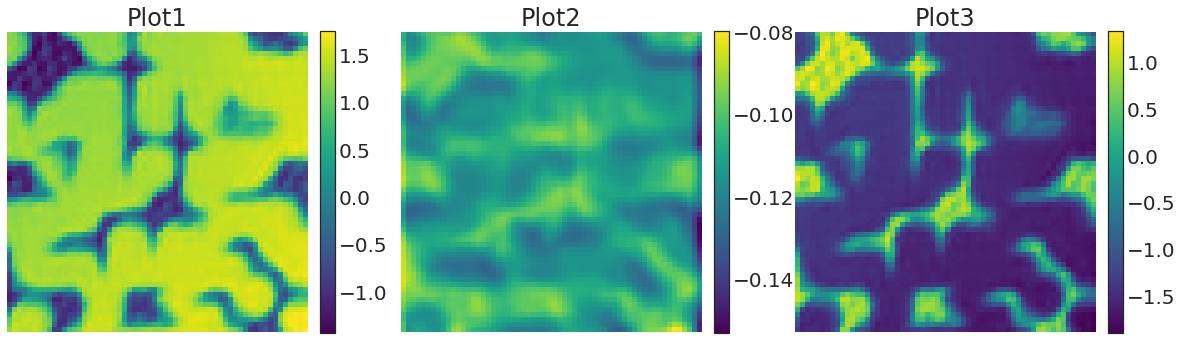

In [33]:
plot3([true_ph[:,:,32,32],stitched_phase_down,stitched_phase_down-true_ph[:,:,32,32]],[])

In [34]:
from sklearn.metrics import mean_squared_error as mse
print ("MSE in amplitude: ", mse(stitched_amp_down, true_amp[:,:,32,32]))
print ("MSE in phase: ", mse(stitched_phase_down, true_ph[:,:,32,32]))

MSE in amplitude:  0.17902702654129285
MSE in phase:  1.6162803159201404
